# Análisis Exploratorio - Estimación de los niveles de obesidad

## Objetivos del Proyecto

El objetivo del proyecto el realizar el pre procesamiento de los datos a la estimación de los niveles de obesidad en individuos de los países de México, Perú y Colombia, con base en sus hábitos alimenticios y condición física.

1. **Pre procesamiento de los datos**:
   Realizar el pre procesameinto datos extraer información significativa de los datos.
   - Feature Ingenier.
   - Selección de variables
   - OneCodEncoding

---


## Descripción de Variables (Dataset de Obesidad)

| Nombre de la Variable | Tipo de Dato (General) | Descripción Detallada |
| :--- | :--- | :--- |
| **`Gender`** | Categórica (Binaria) | Sexo del individuo (Hombre / Mujer). |
| **`Age`** | Numérica (Continua) | Edad del individuo en años. |
| **`Height`** | Numérica (Continua) | Altura del individuo en metros ($m$). |
| **`Weight`** | Numérica (Continua) | Peso del individuo en kilogramos ($kg$). |
| **`family_history_with_overweight`** | Categórica (Binaria) | Historial familiar de sobrepeso (Sí / No). |
| **`FAVC`** | Categórica (Binaria) | Consumo frecuente de alimentos ricos en calorías (Sí / No). |
| **`FCVC`** | Numérica (Discreta) | Frecuencia de consumo de vegetales (generalmente 1, 2 o 3). |
| **`NCP`** | Numérica (Discreta) | Número de comidas principales diarias. |
| **`CAEC`** | Categórica (Ordinal) | Consumo de alimentos entre comidas (No, A veces, Frecuentemente, Siempre). |
| **`SMOKE`** | Categórica (Binaria) | El individuo fuma (Sí / No). |
| **`CH2O`** | Numérica (Discreta) | Consumo de agua diario (generalmente 1, 2 o 3, representando rangos). |
| **`SCC`** | Categórica (Binaria) | Monitoreo del consumo de calorías (Sí / No). |
| **`FAF`** | Numérica (Discreta) | Frecuencia de actividad física (generalmente 0 a 3, representando rangos de días/semana). |
| **`TUE`** | Numérica (Discreta) | Tiempo dedicado al uso de dispositivos tecnológicos (teléfono, TV, etc.) (generalmente 0 a 3, representando rangos de horas/día). |
| **`CALC`** | Categórica (Ordinal) | Frecuencia de consumo de alcohol (No, A veces, Frecuentemente, Siempre). |
| **`MTRANS`** | Categórica (Nominal) | Medio de transporte habitual (Automóvil, Bicicleta, Transporte Público, etc.). |
| **`NObeyesdad`** | **Variable Objetivo** (Categórica Ordinal) | Nivel de Obesidad del individuo. |

---
### Niveles de la Variable Objetivo (`NObeyesdad`)

| Nivel | Descripción |
| :--- | :--- |
| `Insufficient_Weight` | Peso Insuficiente |
| `Normal_Weight` | Peso Normal |
| `Overweight_Level_I` | Sobrepeso Nivel I |
| `Overweight_Level_II` | Sobrepeso Nivel II |
| `Obesity_Type_I` | Obesidad Tipo I |
| `Obesity_Type_II` | Obesidad Tipo II |
| `Obesity_Type_III` | Obesidad Tipo III |

---

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler


In [19]:
%load_ext autoreload
%reload_ext autoreload

In [20]:
data = pd.read_csv('C:/Users/Felipe Londoño M/Documents/Curso MLOps/TrabajoFinal_MLOps/src/dataset/ObesityDataSet_raw_and_data_sinthetic.csv')

### 2. Crea más features...

In [21]:

# Hacemos una copia para no modificar el DataFrame original en caso de errores
df_features = data.copy()

# ----------------------------------------------------------------------
# --- PARTE 1: INGENIERÍA DE CARACTERÍSTICAS(IMC e IHS) ---
# ----------------------------------------------------------------------

# 1. IMC (Índice de Masa Corporal)
df_features['IMC'] = df_features['Weight'] / (df_features['Height']**2)

# 2. Índice de Hábitos Saludables (IHS)

# Preparación de variables con posibles decimales (por ser datos sintéticos)
df_features['FCVC'] = df_features['FCVC'].round().astype(int)
df_features['CH2O'] = df_features['CH2O'].round().astype(int)
df_features['NCP_numeric'] = df_features['NCP'].round()

# Mapeo de puntuaciones
df_features['FAVC_Score'] = df_features['FAVC'].map({'no': 1, 'yes': -1})
df_features['FCVC_Score'] = df_features['FCVC'].map({1: -1, 2: 0, 3: 1})
df_features['NCP_Score'] = 1 - abs(df_features['NCP_numeric'] - 3)
df_features['CAEC_Score'] = df_features['CAEC'].map({
    'No': 2, 'Sometimes': 1, 'Frequently': -1, 'Always': -2
})
df_features['CH2O_Score'] = df_features['CH2O'].map({1: -1, 2: 0, 3: 1})
df_features['CALC_Score'] = df_features['CALC'].map({
    'no': 2, 'Sometimes': 1, 'Frequently': -1, 'Always': -2
})

# Suma de todas las puntuaciones para el IHS
score_cols = [
    'FAVC_Score', 'FCVC_Score', 'NCP_Score',
    'CAEC_Score', 'CH2O_Score', 'CALC_Score'
]
df_features['IHS'] = df_features[score_cols].sum(axis=1)

# Limpiar columnas intermedias
df_features.drop(columns=score_cols + ['NCP_numeric'], inplace=True, errors='ignore')

print("✅ IMC e IHS (Índice de Hábitos Saludables) creados.")




✅ IMC e IHS (Índice de Hábitos Saludables) creados.


In [22]:
# --------------------------------------------------------------------------
# --- PARTE 3: INGENIERÍA DE CARACTERÍSTICAS PARA SEDENTARISMO--------------
# --------------------------------------------------------------------------

# 1. Mapeo de MTRANS (Medio de Transporte) a Puntuación de Actividad
# Asignamos un peso numérico a cada medio de transporte en función de la actividad física que requiere.
mtrans_mapping = {
    'Automobile': -2,              # Mayor sedentarismo
    'Motorbike': -1,               # Sedentarismo intermedio (algo de esfuerzo, pero bajo)
    'Public_Transportation': 0,    # Nivel neutro (caminar a/desde paradas)
    'Bike': 1,                     # Actividad moderada
    'Walking': 2                   # Mayor actividad física
}
df_features['MTRANS_Activity_Score'] = df_features['MTRANS'].map(mtrans_mapping)

# 2. Índice de Actividad y Sedentarismo (AIS)
# Combinamos FAF (Frecuencia de Actividad Física), TUE (Tiempo usando Tecnología) y MTRANS
# FAF y MTRANS_Activity_Score son "pro-actividad" (positivos).
# TUE es "pro-sedentarismo" (negativo).
# (FAF + MTRANS_Activity_Score) - TUE
df_features['AIS'] = (
    df_features['FAF'] + 
    df_features['MTRANS_Activity_Score'] - 
    df_features['TUE']
)

# Limpiar columna intermedia de MTRANS
df_features.drop(columns=['MTRANS_Activity_Score'], inplace=True, errors='ignore')

print("✅ AIS (Índice de Actividad y Sedentarismo) creado.")
print("-" * 50)




✅ AIS (Índice de Actividad y Sedentarismo) creado.
--------------------------------------------------


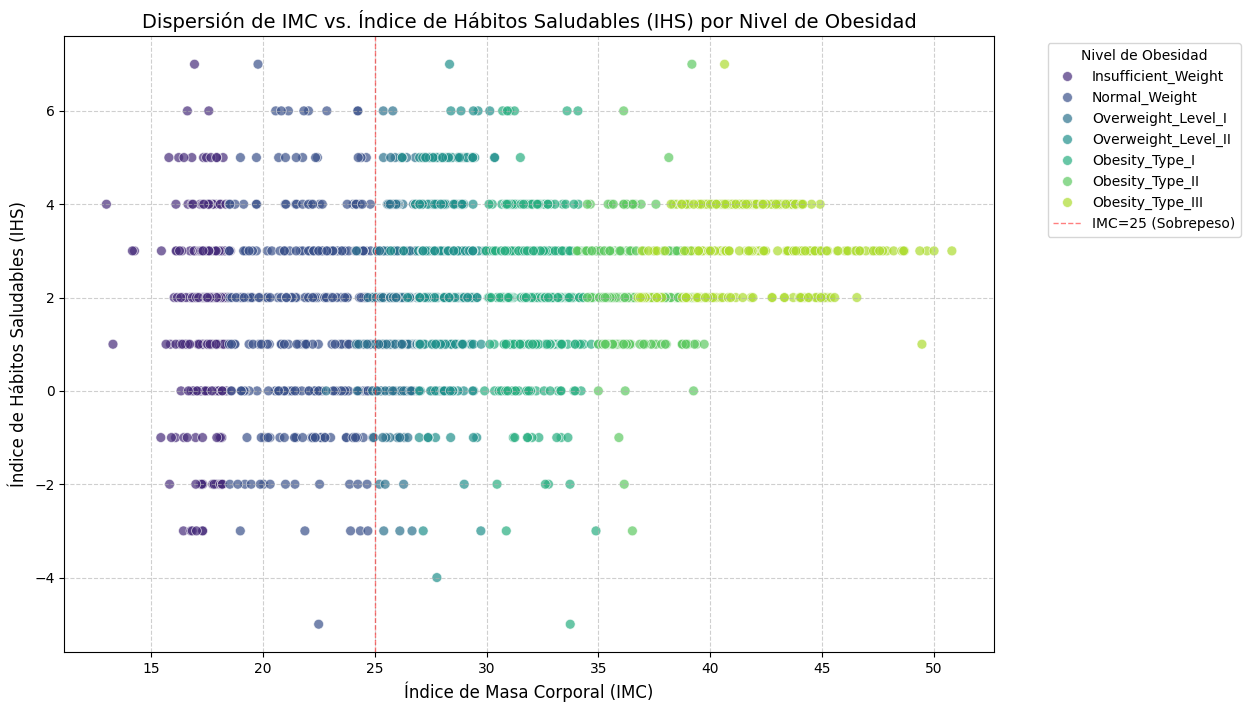

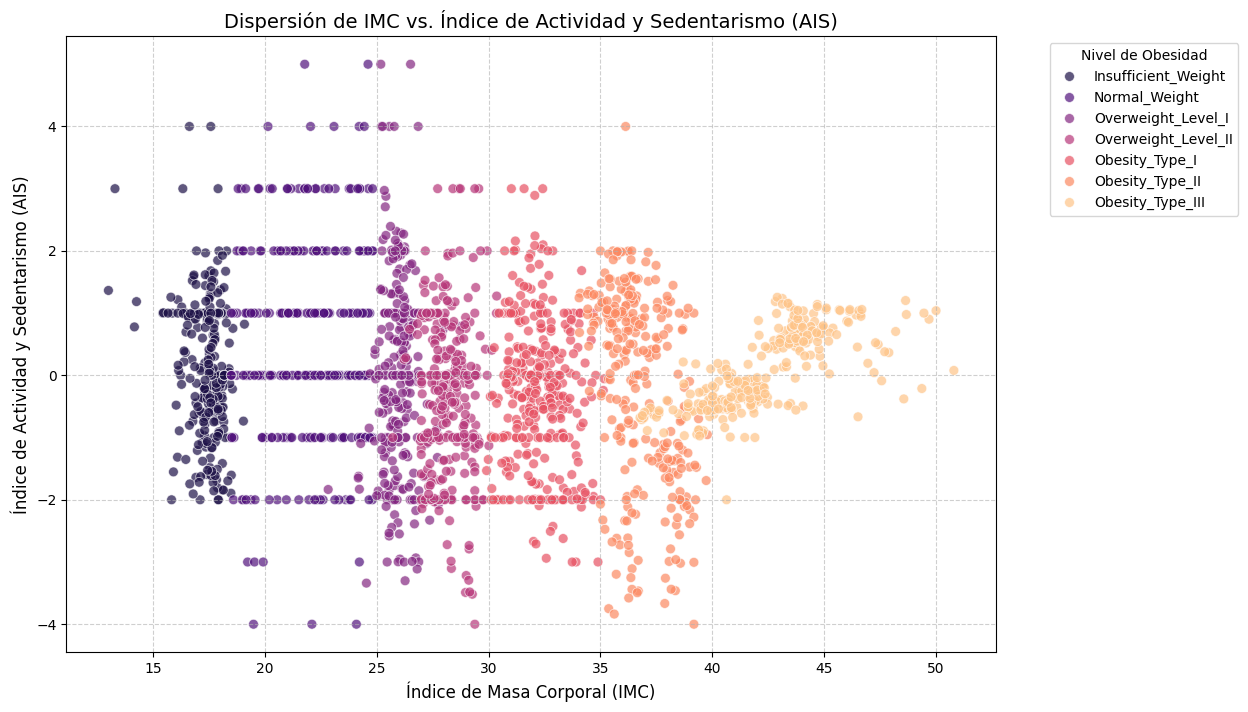


Primeros 5 registros con las nuevas características:
           IMC  IHS       AIS           NObeyesdad
513  17.561293  3.0  1.318170  Insufficient_Weight
582  16.987890 -1.0  0.768811  Insufficient_Weight
581  17.190859  4.0 -1.081224  Insufficient_Weight
580  17.814455  3.0 -0.650505  Insufficient_Weight
579  17.390428  3.0 -0.215529  Insufficient_Weight


In [23]:
# -----------------------------------------------------
# --- PARTE 4: VISUALIZACIÓN IMC vs. IHS (Gráfico) ---
# -----------------------------------------------------

# Ordenar las categorías de NObeyesdad para una leyenda y gráfico coherente
obesity_order = [
    'Insufficient_Weight',
    'Normal_Weight',
    'Overweight_Level_I',
    'Overweight_Level_II',
    'Obesity_Type_I',
    'Obesity_Type_II',
    'Obesity_Type_III'
]
df_features['NObeyesdad'] = pd.Categorical(df_features['NObeyesdad'], categories=obesity_order, ordered=True)
df_features.sort_values('NObeyesdad', inplace=True) 

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='IMC',
    y='IHS',
    hue='NObeyesdad',
    data=df_features,
    palette='viridis',
    s=50,
    alpha=0.7
)

plt.title('Dispersión de IMC vs. Índice de Hábitos Saludables (IHS) por Nivel de Obesidad', fontsize=14)
plt.xlabel('Índice de Masa Corporal (IMC)', fontsize=12)
plt.ylabel('Índice de Hábitos Saludables (IHS)', fontsize=12)
plt.axvline(x=25, color='r', linestyle='--', linewidth=1, alpha=0.5, label='IMC=25 (Sobrepeso)')
plt.legend(title='Nivel de Obesidad', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


# ---------------------------------------------------------------------------------
# --- PARTE 5: VISUALIZACIÓN AIS vs. IMC (Nuevo Gráfico de Actividad) ---
# ---------------------------------------------------------------------------------

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='IMC',
    y='AIS',
    hue='NObeyesdad',
    data=df_features,
    palette='magma',
    s=50,
    alpha=0.7
)

plt.title('Dispersión de IMC vs. Índice de Actividad y Sedentarismo (AIS)', fontsize=14)
plt.xlabel('Índice de Masa Corporal (IMC)', fontsize=12)
plt.ylabel('Índice de Actividad y Sedentarismo (AIS)', fontsize=12)
plt.legend(title='Nivel de Obesidad', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print("\nPrimeros 5 registros con las nuevas características:")
print(df_features[['IMC', 'IHS', 'AIS', 'NObeyesdad']].head())

In [24]:
df_features.head(5)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,IMC,IHS,AIS
513,Female,21.243142,1.598019,44.845655,no,no,3,1.726260,Frequently,no,2,no,1.318170,0.000000,no,Public_Transportation,Insufficient_Weight,17.561293,3.0,1.318170
582,Female,22.926352,1.715597,50.000000,yes,yes,2,3.647154,Frequently,no,1,no,0.866045,0.097234,no,Public_Transportation,Insufficient_Weight,16.987890,-1.0,0.768811
581,Male,18.525525,1.856633,59.258372,yes,yes,3,3.304123,Sometimes,no,2,no,2.038653,1.119877,no,Automobile,Insufficient_Weight,17.190859,4.0,-1.081224
580,Male,17.000000,1.824414,59.295172,yes,yes,2,3.000000,Sometimes,no,2,no,2.349495,1.000000,no,Automobile,Insufficient_Weight,17.814455,3.0,-0.650505
579,Male,17.000000,1.848294,59.409018,yes,yes,2,3.000000,Sometimes,no,2,no,2.784471,1.000000,no,Automobile,Insufficient_Weight,17.390428,3.0,-0.215529


In [25]:
data_final = df_features[['NObeyesdad', 'IMC', 'IHS', 'AIS', 'Gender', 'Age', 'family_history_with_overweight', 'SMOKE', 'SCC']].copy()

In [26]:
data_final.head(5)

,NObeyesdad,IMC,IHS,AIS,Gender,Age,family_history_with_overweight,SMOKE,SCC
513,Insufficient_Weight,17.561293,3.0,1.318170,Female,21.243142,no,no,no
582,Insufficient_Weight,16.987890,-1.0,0.768811,Female,22.926352,yes,no,no
581,Insufficient_Weight,17.190859,4.0,-1.081224,Male,18.525525,yes,no,no
580,Insufficient_Weight,17.814455,3.0,-0.650505,Male,17.000000,yes,no,no
579,Insufficient_Weight,17.390428,3.0,-0.215529,Male,17.000000,yes,no,no


In [27]:
# --- 2. CODIFICACIÓN DE VARIABLES BINARIAS ---

# 2.1 Mapeo de variables binarias
binary_mapping_gender = {'Male': 1, 'Female': 0}
binary_mapping_yes_no = {'yes': 1, 'no': 0}

# 2.2 Aplicar el mapeo
data_final['Gender'] = data_final['Gender'].map(binary_mapping_gender)
data_final['family_history_with_overweight'] = data_final['family_history_with_overweight'].map(binary_mapping_yes_no)
data_final['SMOKE'] = data_final['SMOKE'].map(binary_mapping_yes_no)
data_final['SCC'] = data_final['SCC'].map(binary_mapping_yes_no)

print("✅ Codificación de binarias (Gender, family_history_with_overweight, SMOKE, SCC) completada.")


# --- 3. ESCALADO DE VARIABLES CONTINUAS (StandardScaler) ---

# 3.1 Identificar las variables continuas a escalar
continuous_cols = ['Age', 'IMC', 'IHS', 'AIS']

# 3.2 Inicializar el Escalador
scaler = StandardScaler()

# 3.3 Aplicar el escalado (fit y transform)
data_final[continuous_cols] = scaler.fit_transform(data_final[continuous_cols])

# 3.4 Crear el DataFrame final con las variables procesadas
data_final_procesada = data_final

print("✅ Escalado (StandardScaler) de variables continuas (Age, IMC, IHS, AIS) completado.")
print("-" * 50)
print("DataFrame final listo para Modelado:")
print(data_final_procesada.head())

✅ Codificación de binarias (Gender, family_history_with_overweight, SMOKE, SCC) completada.
✅ Escalado (StandardScaler) de variables continuas (Age, IMC, IHS, AIS) completado.
--------------------------------------------------
DataFrame final listo para Modelado:
              NObeyesdad       IMC       IHS       AIS  Gender       Age  \
513  Insufficient_Weight -1.515570  0.529357  1.023321       0 -0.483801   
582  Insufficient_Weight -1.587161 -1.885496  0.606141       0 -0.218497   
581  Insufficient_Weight -1.561820  1.133070 -0.798767       1 -0.912145   
580  Insufficient_Weight -1.483962  0.529357 -0.471681       1 -1.152595   
579  Insufficient_Weight -1.536903  0.529357 -0.141362       1 -1.152595   

     family_history_with_overweight  SMOKE  SCC  
513                               0      0    0  
582                               1      0    0  
581                               1      0    0  
580                               1      0    0  
579                          

## **Conclusiones y Limpieza de Variables**

**1. Validación de Potencia:** Los gráficos de dispersión confirmaron que el IMC es el factor dominante, mientras que IHS y AIS son fuertemente complementarios, ayudando a diferenciar los niveles de obesidad, especialmente en los rangos de sobrepeso.

**2. Reducción de Multicolinealidad**: Decidimos excluir las variables originales que eran redundantes (como Weight, Height y las variables de hábitos y actividad) para evitar la multicolinealidad y simplificar el modelo, ya que las nuevas características capturan mejor su esencia.

**3.Procesamiento Final:**

 - Codificación: Las variables binarias (Gender, family_history_with_overweight, SMOKE, SCC) se mapearon a valores de 0 y 1.

 - Escalado: Las variables continuas (Age, IMC, IHS, AIS) se estandarizaron usando StandardScaler (media 0, desviación estándar 1), un paso crítico para modelos basados en distancia y gradientes.

 - El DataFrame final, está limpio y optimizado, listo para el entrenamiento del modelo.